In [1]:
import random
import investpy
import requests
import urllib.request
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
from functools import reduce
import urllib.request
import re
import pandas as pd
from datetime import datetime
import missingno as msno
import matplotlib as mpl
import matplotlib.lines as mlines
import pandas_ta as ta
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
import warnings
warnings.filterwarnings("ignore")

2023-04-22 20:29:34.026139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Import data

In [41]:
final_df = pd.read_csv('final_df_next_7th_day_15.csv').reset_index(drop=True)
final_df.head()

,Date,Close,High,Market_Capitalization,sma7 Close,tema7 Close,Low,tema30 Close,bband_upper7 High,dema7 Close,bband_upper7 Average_price_per_day,tema7 Market_Capitalization,dema7 Low,dema7 Average_price_per_day,sma7 High,sma7 Market_Capitalization,next_7th_day_closing_price
0,2010-07-17,0.000000e+00,0.000000e+00,0.000000e+00,1.975682e-07,2.358623e-07,0.000000e+00,5.195542e-08,4.816806e-07,2.049455e-07,4.463649e-07,4.208173e-08,2.101802e-07,2.051912e-07,1.942355e-07,3.038450e-08,0.0545
1,2010-07-18,5.298462e-07,5.204277e-07,6.270789e-08,1.975682e-07,2.358623e-07,5.393027e-07,5.195542e-08,4.816806e-07,2.049455e-07,4.463649e-07,4.208173e-08,2.101802e-07,2.051912e-07,1.942355e-07,3.038450e-08,0.0505
2,2010-07-19,4.558453e-07,4.477423e-07,9.897273e-08,1.975682e-07,2.358623e-07,4.639811e-07,5.195542e-08,4.816806e-07,2.049455e-07,4.463649e-07,4.208173e-08,2.101802e-07,2.051912e-07,1.942355e-07,3.038450e-08,0.0560
3,2010-07-20,3.655643e-07,3.590660e-07,7.901608e-08,1.975682e-07,2.358623e-07,3.720887e-07,5.195542e-08,4.816806e-07,2.049455e-07,4.463649e-07,4.208173e-08,2.101802e-07,2.051912e-07,1.942355e-07,3.038450e-08,0.0600
4,2010-07-21,4.321650e-07,4.244829e-07,7.537077e-08,1.975682e-07,2.358623e-07,4.398782e-07,5.195542e-08,4.816806e-07,2.049455e-07,4.463649e-07,4.208173e-08,2.101802e-07,2.051912e-07,1.942355e-07,3.038450e-08,0.0589


In [74]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    MSE = metrics.mean_squared_error(y, ypred,squared=True)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    R2 = metrics.r2_score(y, ypred)
    return MAE,MSE,RMSE,R2

def plot_result(df,title=None):
    plt.figure(figsize=(25, 6))
    plt.plot( df.iloc[:, 1], label='Actual')
    plt.plot( df.iloc[:, 2], label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

### XGBoost

In [70]:
# Determine the size of the train and test set
test_size = 0.3
n_test = int(np.round(len(final_df) * test_size))
train_split = final_df[:len(final_df)-n_test]
test_split = final_df[len(final_df)-n_test:]

x_train = train_split.drop(['next_7th_day_closing_price','Date'],axis=1).values
x_test = test_split.drop(['next_7th_day_closing_price','Date'],axis=1).values

y_train = train_split['next_7th_day_closing_price'].reset_index(drop=True).values
y_test = test_split['next_7th_day_closing_price'].reset_index(drop=True).values

# Set up the XGBoost model with simplified trees and no regularization
xgbm_reg = xgb.XGBRegressor(n_estimators=300, max_depth=6, objective='reg:squarederror', learning_rate=0.01, n_jobs=-1)

# Train the model with early stopping
xgbm_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=10, verbose=False)

# Make predictions on the training and test sets
ytrain_pred_xgb = xgbm_reg.predict(x_train)
ytest_pred_xgb = xgbm_reg.predict(x_test)

MAE_train,MSE_train,RMSE_train,R2_train = calculate_metrics(y_train,ytrain_pred_xgb)
MAE_test,MSE_test,RMSE_test,R2_test = calculate_metrics(y_test,ytest_pred_xgb)

xgb_result_test_df = pd.DataFrame()
xgb_result_test_df['Date'] = test_split['Date']
xgb_result_test_df['y_test'] = test_split['next_7th_day_closing_price']
xgb_result_test_df['y_test_pred'] = ytest_pred_xgb.flatten()


xgb_result_train_df = pd.DataFrame()
xgb_result_train_df['Date'] = train_split['Date']
xgb_result_train_df['y_train'] = train_split['next_7th_day_closing_price']
xgb_result_train_df['y_train_pred'] = ytrain_pred_xgb.flatten()

In [71]:
print("Mean Absolute Error (MAE) for Training:", MAE_train)
print("Mean Squared Error (MSE) for Training:", MSE_train)
print("Root Mean Squared Error (RMSE) for Training:", RMSE_train)
print("R-squared score (R2) for Training:", R2_train)
print("********************************************")
print("Mean Absolute Error (MAE) for Testing:", MAE_test)
print("Mean Squared Error (MSE) for Testing:", MSE_test)
print("Root Mean Squared Error (RMSE) for Testing:", RMSE_test)
print("R-squared score (R2) for Testing:", R2_test)

Root Mean Squared Error (RMSE) for Training: 310.72945363741195
Mean Absolute Error (MAE) for Training: 115.66169619407536
********************************************
Root Mean Squared Error (RMSE) for Testing: 20266.852990504936
Mean Absolute Error (MAE) for Testing: 13972.062799054776


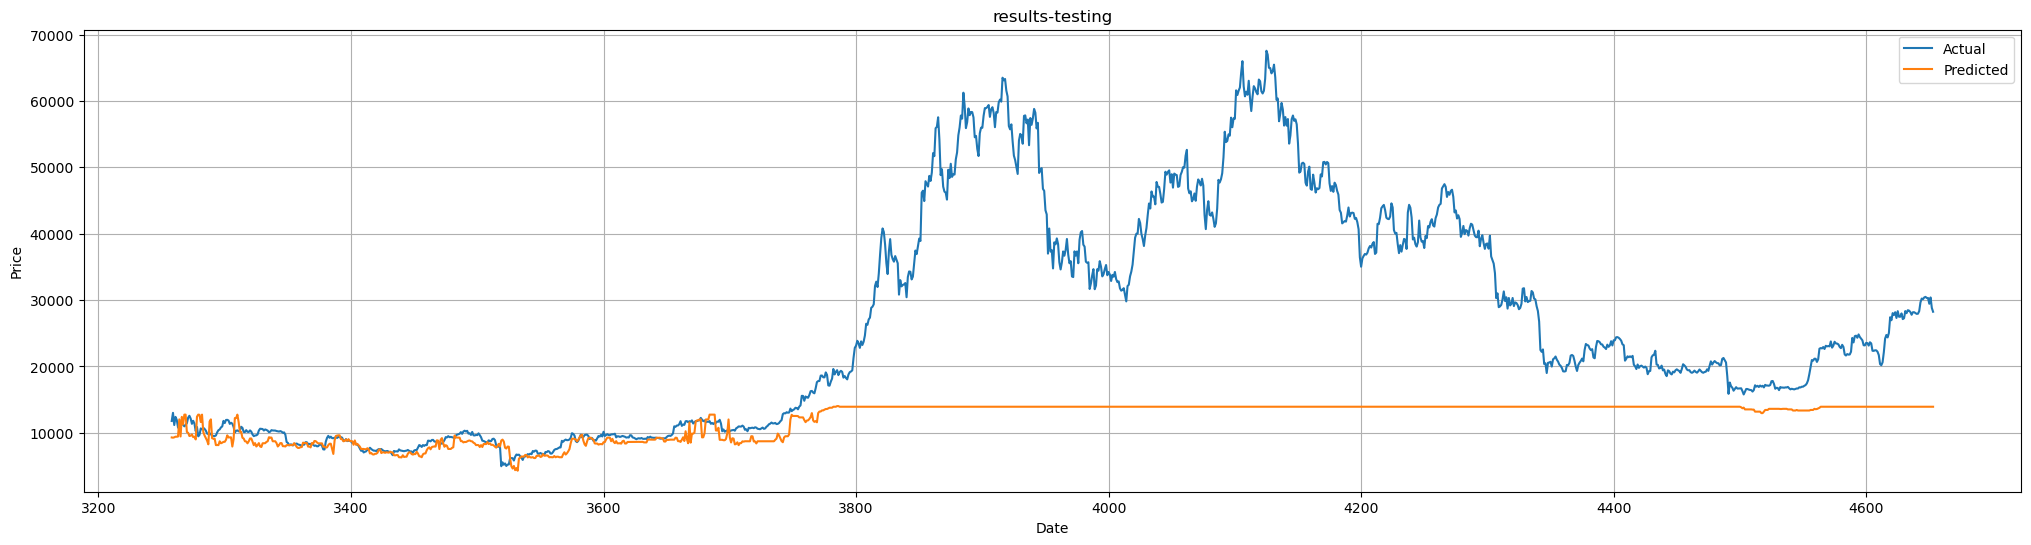

In [72]:
plot_result(xgb_result_test_df,'results-testing')

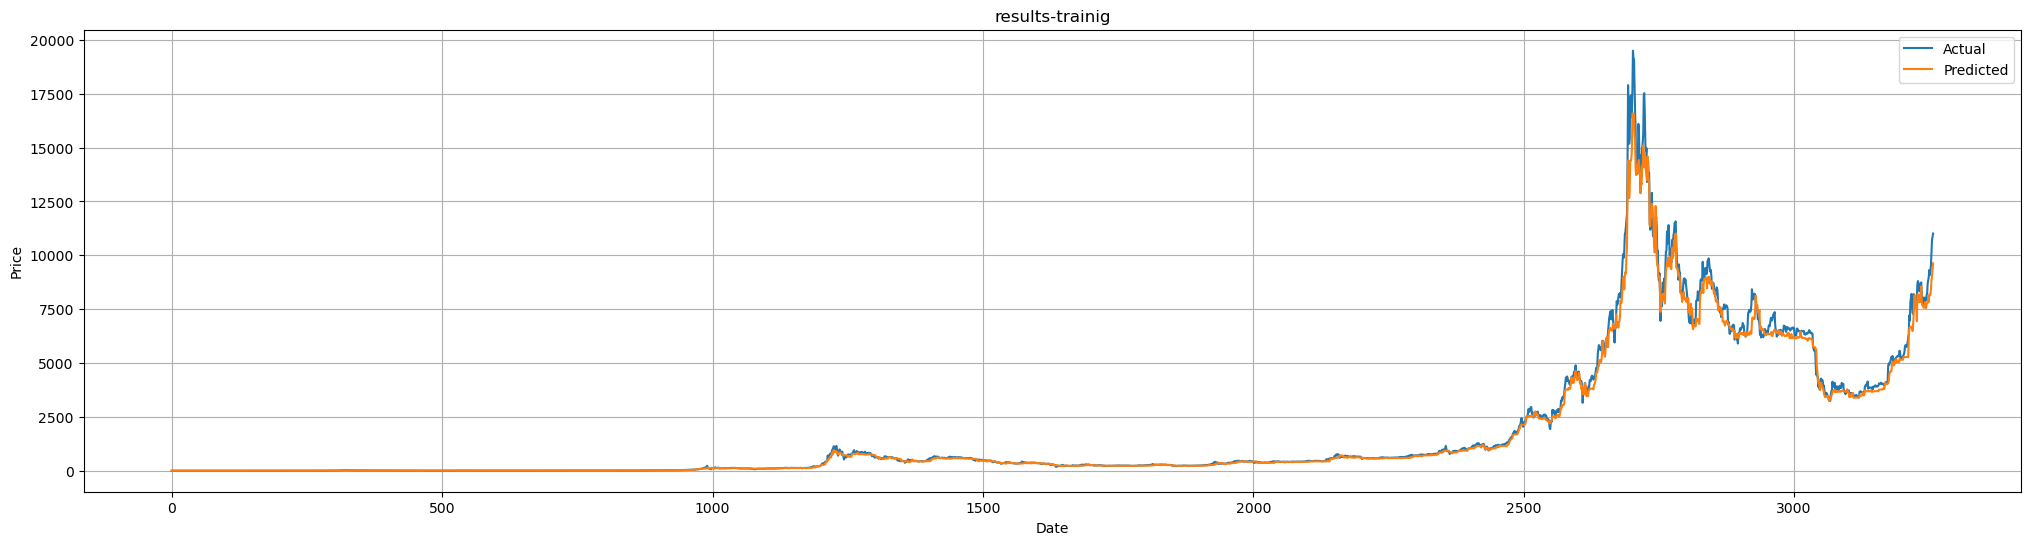

In [73]:
plot_result(xgb_result_train_df,'results-trainig')